# Interpret regression models using California Housing Prices Dataset

This notebook demonstrates how to apply Captum library on a regression model and understand important features, layers / neurons that contribute to the prediction

In [1]:
import numpy as np

from os import path


import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [2]:
california = fetch_california_housing()


# https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset
feature_names = california.feature_names
"""
Features:
MedInc median income in block group
HouseAge median house age in block group
AveRooms average number of rooms per household
AveBedrms average number of bedrooms per household
Population block group population
AveOccup average number of household members
Latitude block group latitude
Longitude block group longitude
 
The target variable is the median house value for California districts, 
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per census block group. 
A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data 
(a block group typically has a population of 600 to 3,000 people).
"""

#take first n examples for speed up
n = 600
X = california.data[:n]
y = california.target[:n]

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)

In [5]:
### Data Exploration

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

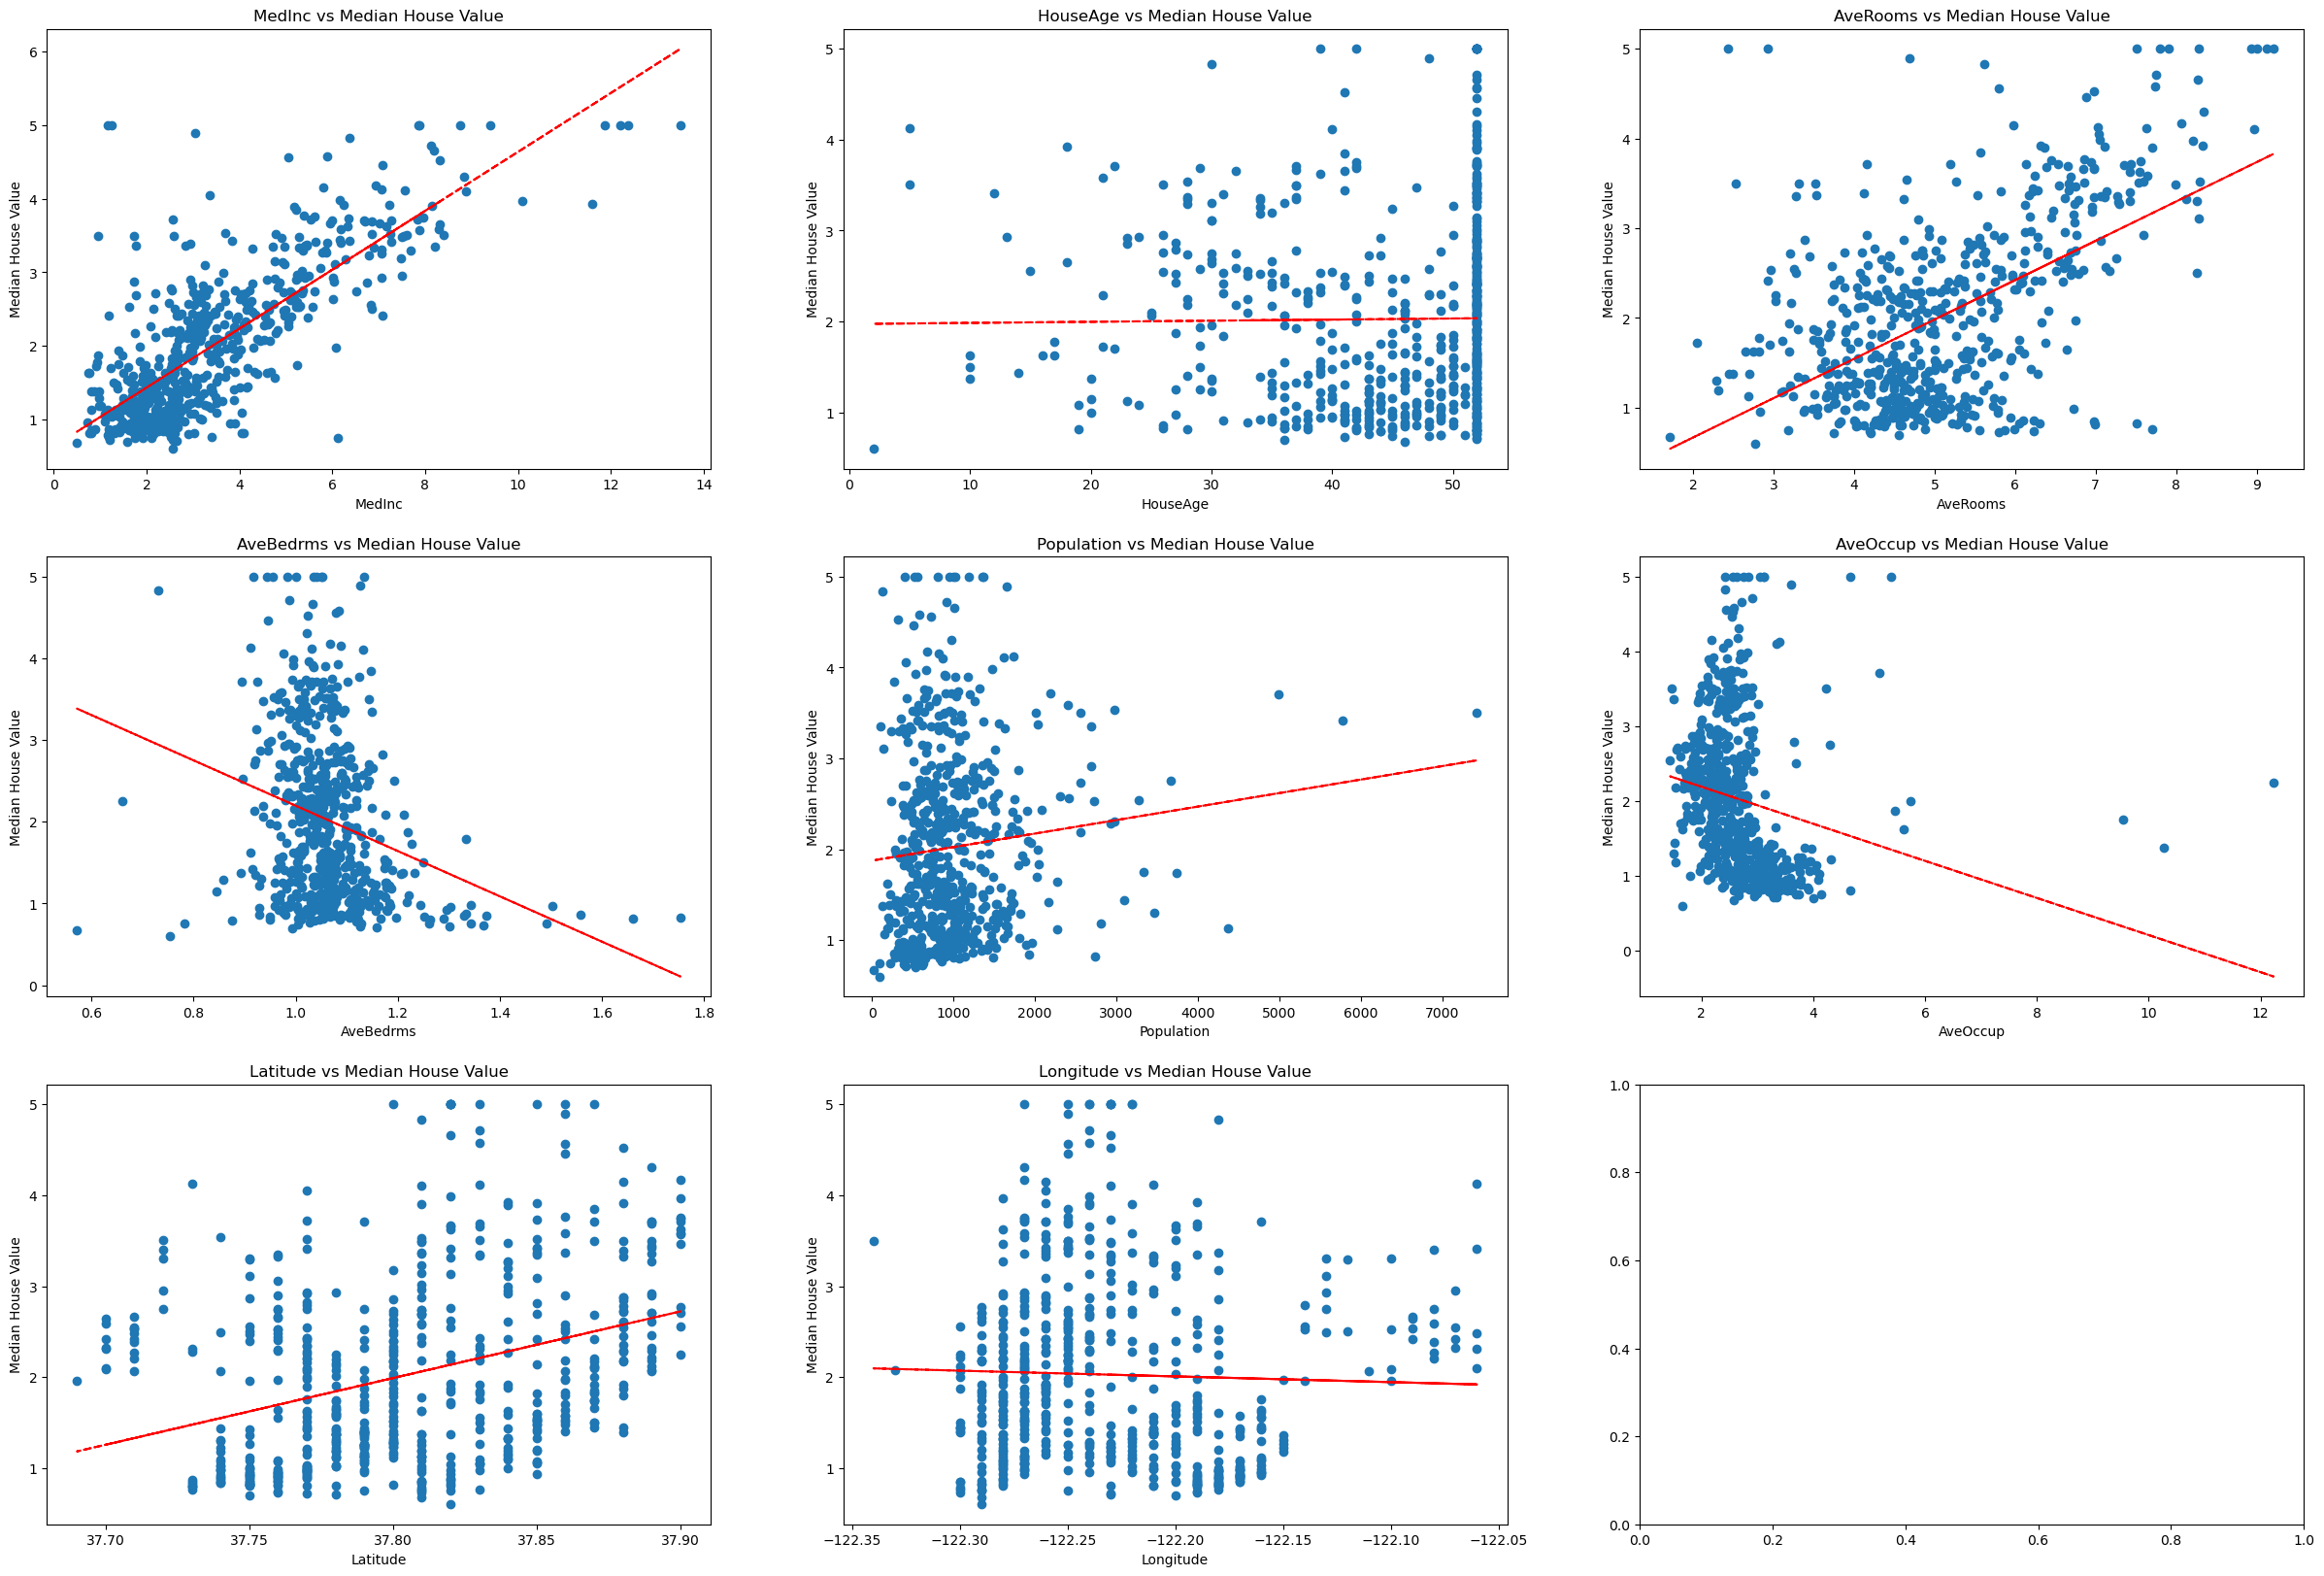

In [7]:
fig, axs = plt.subplots(nrows = 3, ncols=3, figsize=(30, 20))
for i, (ax, col) in enumerate(zip(axs.flat, feature_names)):    
    x = X[:,i]
    pf = np.polyfit(x, y, 1)
    p = np.poly1d(pf)

    ax.plot(x, y, 'o')
    ax.plot(x, p(x),"r--")

    ax.set_title(col + ' vs Median House Value')
    ax.set_xlabel(col)
    ax.set_ylabel('Median House Value')

In [8]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=10, shuffle=True)

In [9]:
batch_size = 50
num_epochs = 200
learning_rate = 0.0001
size_hidden1 = 100
size_hidden2 = 50
size_hidden3 = 10
size_hidden4 = 1

In [10]:
class CaliforniaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(8, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(size_hidden2, size_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(size_hidden3, size_hidden4)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [11]:
model = CaliforniaModel()
model.train()

CaliforniaModel(
  (lin1): Linear(in_features=8, out_features=100, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (lin3): Linear(in_features=50, out_features=10, bias=True)
  (relu3): ReLU()
  (lin4): Linear(in_features=10, out_features=1, bias=True)
)

In [12]:
criterion = nn.MSELoss(reduction='sum')

In [13]:
def train(model_inp, num_epochs = num_epochs):
    optimizer = torch.optim.RMSprop(model_inp.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in train_iter:
            # forward pass
            outputs = model_inp(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

In [14]:
def train_load_save_model(model_obj, model_path):
    if path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model_obj.load_state_dict(torch.load(model_path))
    else:    
        # train model
        train(model_obj)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model_obj.state_dict(), model_path)

In [15]:
SAVED_MODEL_PATH = 'models/california_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH)

Loading pre-trained model from: models/california_model.pt


In [16]:
model.eval()
outputs = model(X_test)
err = np.sqrt(mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  0.6579745


## Comparing different attribution algorithms

In [17]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


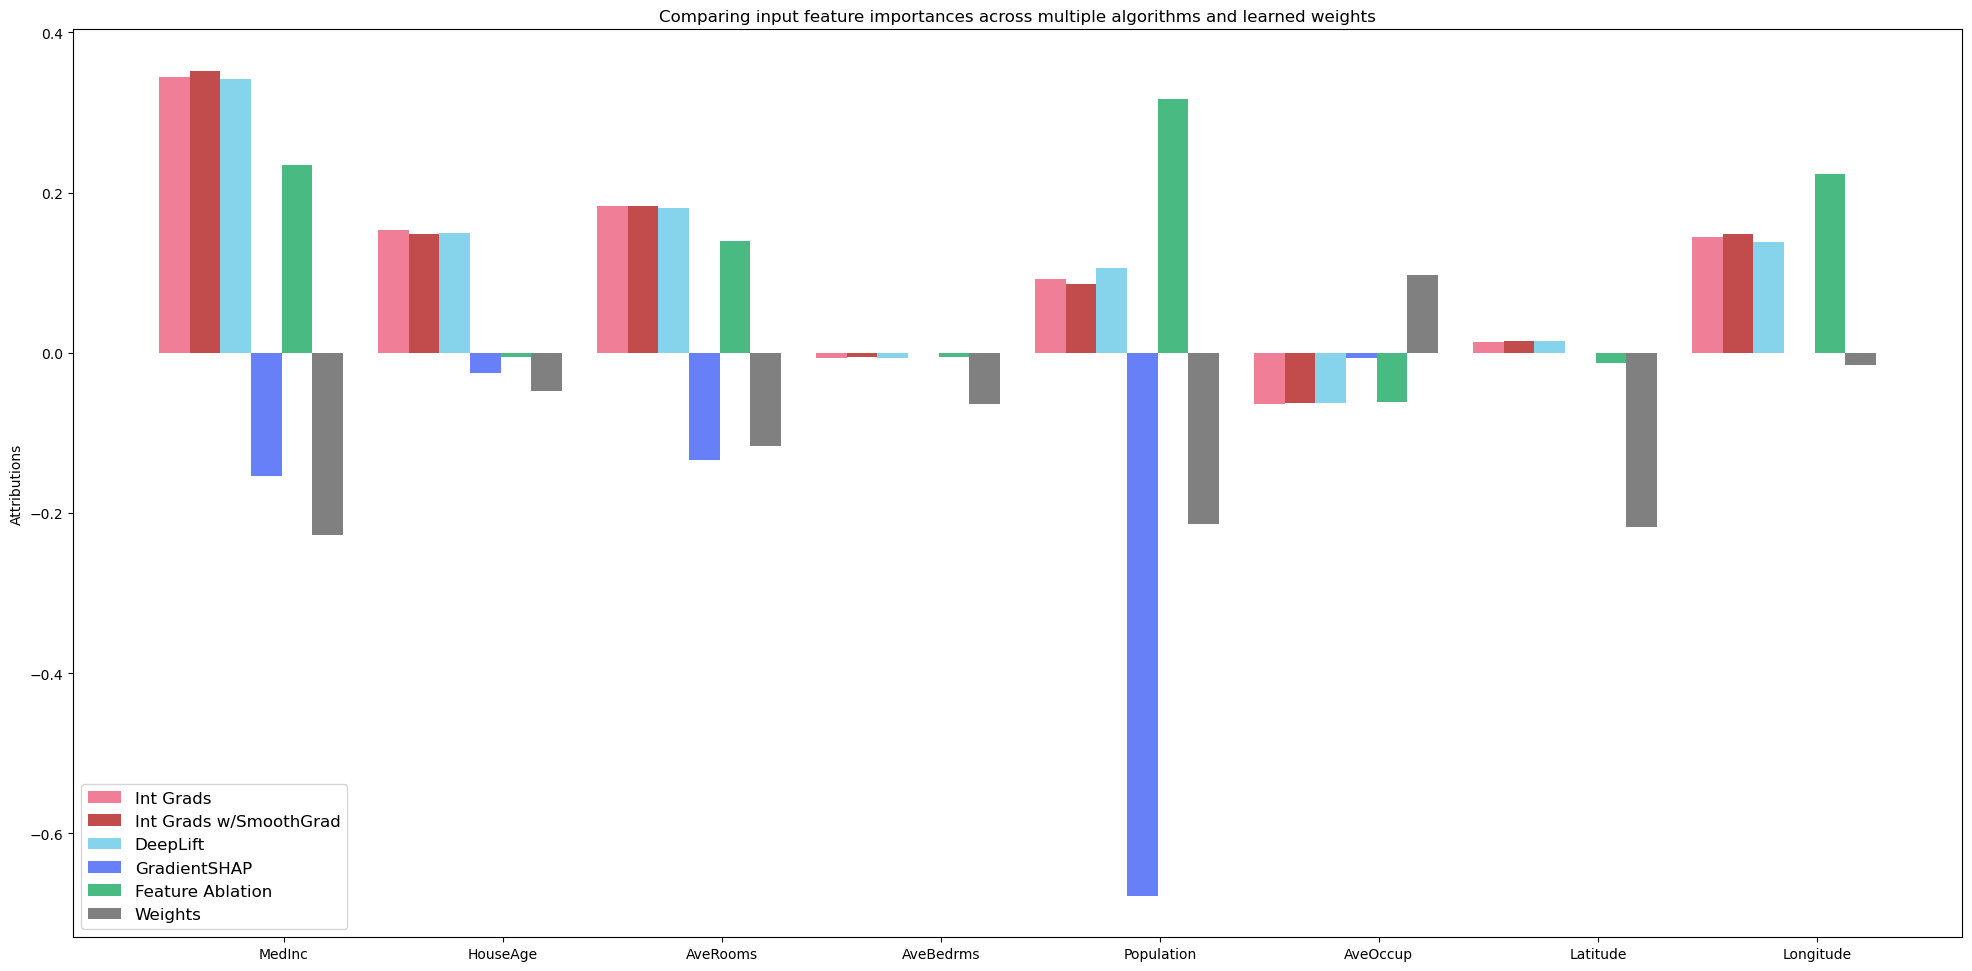

In [18]:
# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.lin1.weight[0].detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

In [19]:
# Compute the attributions of the output with respect to the inputs of the fourth linear layer
lc = LayerConductance(model, model.lin4)

# shape: test_examples x size_hidden
lc_attr_test = lc.attribute(X_test, n_steps=100, attribute_to_layer_input=True)

# weights from forth linear layer
# shape: size_hidden4 x size_hidden3
lin4_weight = model.lin4.weight

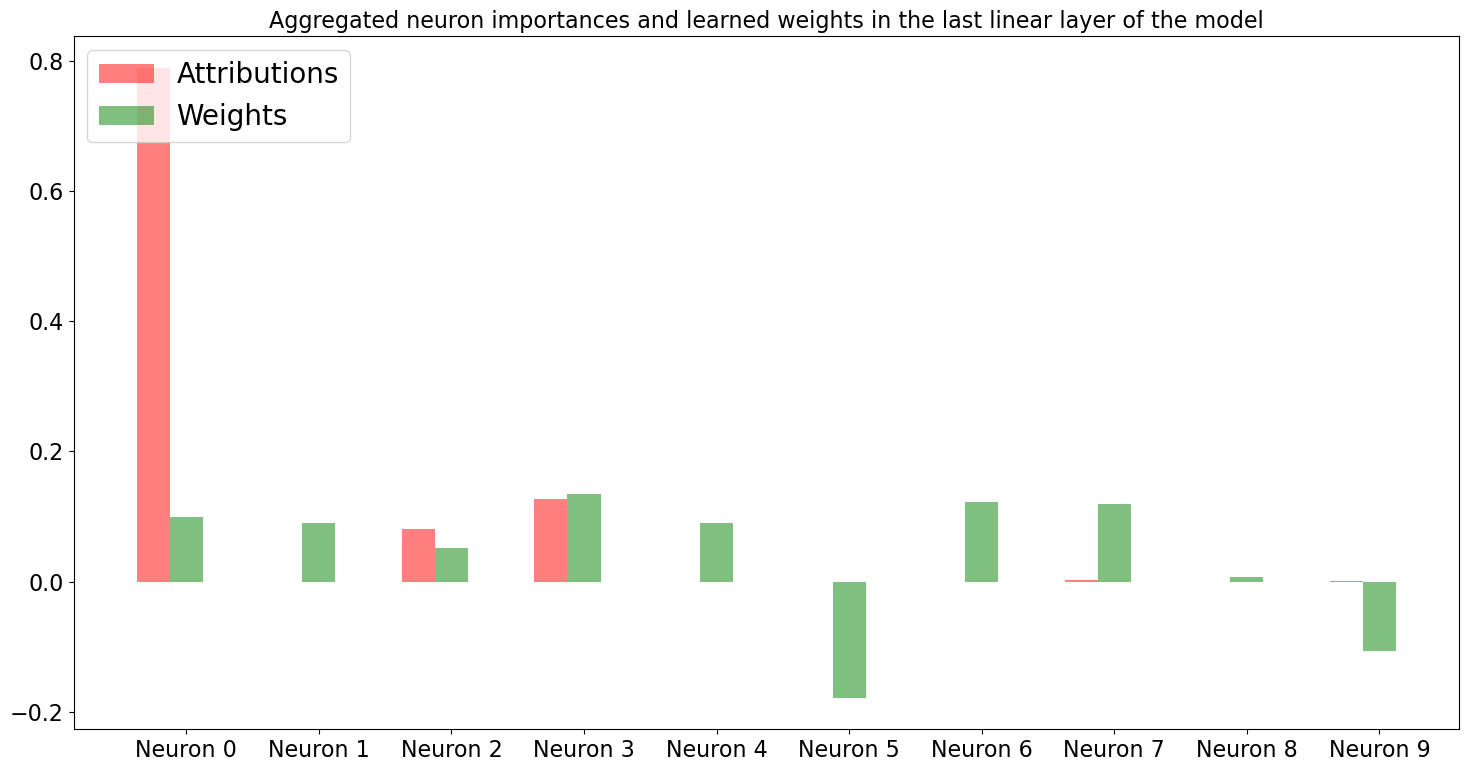

In [20]:
plt.figure(figsize=(15, 8))

x_axis_data = np.arange(lc_attr_test.shape[1])

y_axis_lc_attr_test = lc_attr_test.mean(0).detach().numpy()
y_axis_lc_attr_test = y_axis_lc_attr_test / np.linalg.norm(y_axis_lc_attr_test, ord=1)

y_axis_lin4_weight = lin4_weight[0].detach().numpy()
y_axis_lin4_weight = y_axis_lin4_weight / np.linalg.norm(y_axis_lin4_weight, ord=1)

width = 0.25
legends = ['Attributions','Weights']
x_axis_labels = [ 'Neuron {}'.format(i) for i in range(len(y_axis_lin4_weight))]

ax = plt.subplot()
ax.set_title('Aggregated neuron importances and learned weights in the last linear layer of the model')

ax.bar(x_axis_data + width, y_axis_lc_attr_test, width, align='center', alpha=0.5, color='red')
ax.bar(x_axis_data + 2 * width, y_axis_lin4_weight, width, align='center', alpha=0.5, color='green')
plt.legend(legends, loc=2, prop={'size': 20})
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_labels)

plt.show()